# Imports

In [1]:
!ls -alfhg
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import skimage.io

import sys

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Create checkerboard image

In [2]:
# Make checkerboard ramp scene
mode = 1

def make_checkerboard(pixperblock, shape, dotsoffset=0):
    radius = pixperblock // 5
    print('radius:', radius)
    numrow = shape[0]//pixperblock
    numcol = shape[1]//pixperblock
    numdots = numrow*numcol
    imgshape = (numrow*pixperblock, numcol*pixperblock)
    texture = np.zeros(shape=imgshape)
    rowprev, row = 0, 0
    for i in range(numrow):
        row += pixperblock
        colprev, col = 0, 0
        for j in range(numcol):
            col += pixperblock
            h = col-colprev
            w = row-rowprev
            if i % 2 == 0:
                texture[rowprev:row, colprev:col] = 0 if j % 2 == 0 else 1
            else:
                texture[rowprev:row, colprev:col] = 1 if j % 2 == 0 else 0
            colprev = col
        rowprev = row

    if mode == 1:
        color1 = (1, 1, 1)
        color2 = (0, 0, 0)
    else:
        color1 = (0, 0, 0)
        color2 = (1, 1, 1)

    center = ((numcol//2+dotsoffset) * pixperblock + pixperblock //
              2, numrow//2 * pixperblock + pixperblock//2)
    cv2.circle(texture, center, radius, color1, -1)

    center = ((numcol//2+dotsoffset+1) * pixperblock + pixperblock //
              2, numrow//2 * pixperblock + pixperblock//2)
    cv2.circle(texture, center, radius, color2, -1)

    center = ((numcol//2+dotsoffset) * pixperblock + pixperblock //
              2, (numrow//2-1) * pixperblock + pixperblock//2)
    cv2.circle(texture, center, radius, color2, -1)

    ypad = shape[0]-texture.shape[0]
    xpad = shape[1]-texture.shape[1]
    texture = np.pad(
        texture, ((ypad//2, ypad-ypad//2), (xpad//2, xpad-xpad//2)))
    texture = texture/np.max(texture)

    return texture

radius: 54


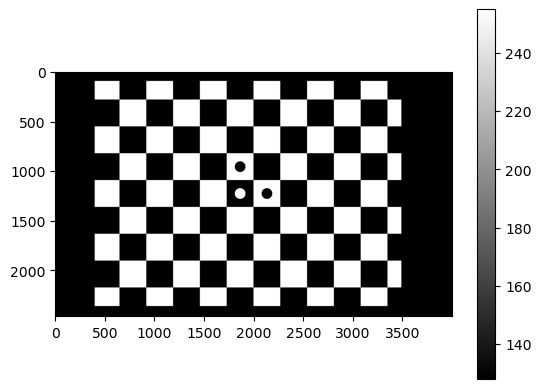

In [3]:
pixperblock = 270
SLMshape = (2464, 4000) # (2160,3840)
dotsoffset = -1
texture = make_checkerboard(pixperblock=pixperblock, shape=SLMshape, dotsoffset=dotsoffset)

texture[:, :100] = 0
texture[:, -100:] = 0
texture[:100, :] = 0
texture[-100:, :] = 0

texture = texture/2 + 0.5
texture = np.round(texture*255).astype(np.uint8)
texture[:, :400] = np.min(texture)
texture[:, 3490:] = np.min(texture)

plt.figure(dpi=100)
plt.imshow(texture, cmap='gray')
plt.colorbar()
plt.show()

skimage.io.imsave('checkerboard.png', texture)

# Display checkerboard image

Steps:
1. run `python code/display_single.py`
2. press `p` to display the image saved to `homography/checkerboard.png`
3. run the code below to capture an image

```
from polarizedcamera import PolarizedCamera
polarized_camera = PolarizedCamera()
polarized_camera.set_features(exposure_time=47178.6, gain=18.9)
images = polarized_camera.capture_dp_image(savefolder=savefolder, saveimages=False, savegridview=False)
imgrgb_l, imgrgb_r = images[2], images[0]
imgrgb_total = images[3] #(imgrgb_l + imgrgb_r) / 2
skimage.io.imsave('50mm_customdpsensor/captured.jpg', cv2.cvtColor(imgrgb_total, cv2.COLOR_BGR2RGB))
```

# Read the images

In [18]:
import sys
sys.path.append('..')
sys.path.append('../code/')

In [19]:
import subprocess
import skimage
import numpy as np
import matplotlib.pyplot as plt

from params import Params

from utils_isp import *
# from autofocus_loop import get_extract_commands, get_rename_commands, get_clean_intermediates_commands
from utils_aif import *

loadfolder = '50mm_customdpsensor' #'85mm_0918' #'85mm_new'
load_image_name = 'captured_1017_135°'

### read images (85mm Version)
img_original_path = 'checkerboard.png'
img_captured_path = f'{loadfolder}/{load_image_name}.jpg'
img_original = skimage.io.imread(img_original_path) / 255
img_captured = skimage.io.imread(img_captured_path) / 255

# De-vignetting the captured image

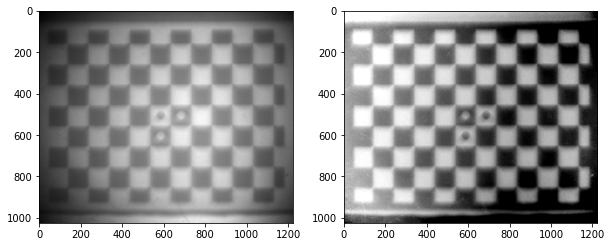

In [20]:
# de-vignet the captured image
rows, cols = img_captured.shape[:2]

# Process captured image 
img_captured = img_captured - np.min(img_captured)
img_captured = img_captured / np.max(img_captured)
img_captured = np.round(img_captured*255).astype(np.uint8)
img_captured = cv2.cvtColor(img_captured, cv2.COLOR_RGB2GRAY)

# Create a vignette mask
kernel_x = cv2.getGaussianKernel(cols, 4000)
kernel_y = cv2.getGaussianKernel(rows, 4000)
kernel = kernel_y * kernel_x.T
mask = 255 * kernel / np.linalg.norm(kernel)
mask1 = cv2.normalize(mask, None, alpha=10, beta=250,
                      norm_type=cv2.NORM_MINMAX)
mask1 = np.uint8(mask1)
img_captured_corrected1 = cv2.divide(img_captured, mask1, scale=255)
img_captured_corrected1 = (255 - img_captured_corrected1).astype(np.uint8) / 255.0
img_captured_corrected1 = img_captured_corrected1 - img_captured_corrected1.min()
img_captured_corrected1 = img_captured_corrected1 / img_captured_corrected1.max()
img_captured_corrected1 = np.clip(img_captured_corrected1*1.5, 0, 1)
img_captured_corrected = np.round(img_captured_corrected1*255).astype(np.uint8)

plt.figure(figsize=(20/2, 12/2))
plt.subplot(1, 2, 1)
plt.imshow(img_captured, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img_captured_corrected, 'gray')
plt.show()

In [21]:
skimage.io.imsave(f'{loadfolder}/{load_image_name}_1.jpg', img_captured_corrected)

# Find corners

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import skimage.io
import copy

import sys

In [23]:
def findCorners(gray, criteria, shape, flags=cv2.CALIB_CB_MARKER):
    if len(gray.shape)>2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCornersSB(gray,shape,flags=flags)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        img_drawn = cv2.drawChessboardCorners(copy.deepcopy(gray), shape, corners2, ret)
        return img_drawn, corners2
    print('No corners found')
    return None, None

# checkerboard shape
shape = (8, 11) #(7,13)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

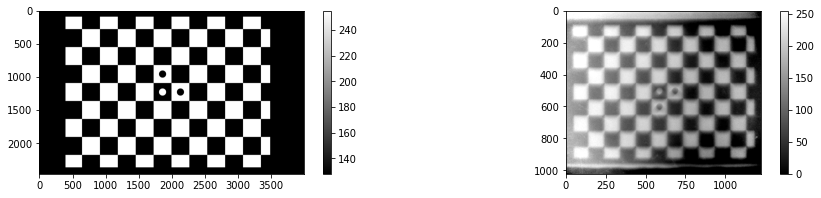

((2464, 4000), (1024, 1224), dtype('uint8'), dtype('uint8'), 255, 255)

In [24]:
img_original = skimage.io.imread('checkerboard.png')
# img_captured = skimage.io.imread('85mm/img_captured_corrected.png')
loadpath = f'{loadfolder}/{load_image_name}_1.jpg'
img_captured = skimage.io.imread(loadpath).astype(np.uint8)#[:,:,1] #[:-60, :, :]

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.imshow(img_original, 'gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(img_captured, 'gray')
plt.colorbar()
plt.show()
img_original.shape, img_captured.shape, img_original.dtype, img_captured.dtype, img_original.max(), img_captured.max()

detected slm checkerboard corners: (88, 2) 88
detected camera checkerboard corners: (88, 2) 88


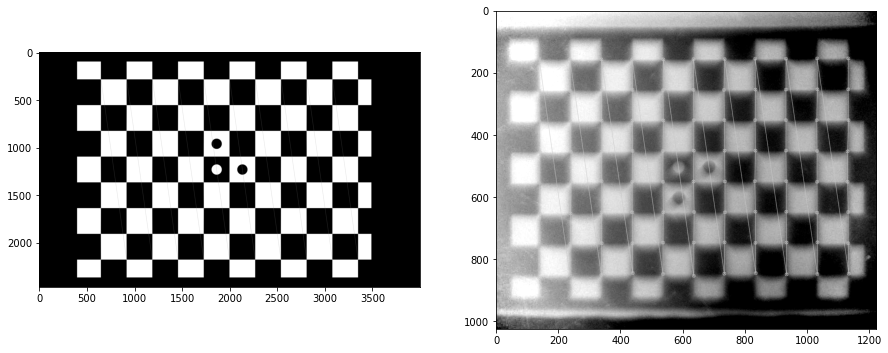

In [25]:
# find corners in slm Coordinates
img_original_drawn, corners_original = findCorners(img_original, criteria, shape=shape, flags=None)
corners_original = np.squeeze(corners_original)
print('detected slm checkerboard corners:', 
      corners_original.shape, shape[0]*shape[1])

# find corners in camera Coordinates
# img_captured = skimage.io.imread('85mm/img_captured3.png') #[:-60, :, :]
# img_captured = skimage.transform.resize(img_captured, (2140, 3860))
# img_captured = np.round(img_captured*255).astype(np.uint8)
img_captured_drawn, corners_captured = findCorners(img_captured, criteria, shape=shape, flags=None)
corners_captured = np.squeeze(corners_captured) #* 1.522
print('detected camera checkerboard corners:', 
      corners_captured.shape, shape[0]*shape[1])

plt.figure(figsize=(15,33))
plt.subplot(1,2,1)
plt.imshow(img_original_drawn, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_captured_drawn, cmap='gray')
plt.show()

In [26]:
# check the order of the detected corners
print('corners_original', corners_original)
print('corners_captured', corners_captured)

corners_original [[ 649.5     2176.5    ]
 [ 649.49994 1906.4999 ]
 [ 649.50006 1636.5    ]
 [ 649.5     1366.5001 ]
 [ 649.4999  1096.4999 ]
 [ 649.5      826.4999 ]
 [ 649.5      556.50006]
 [ 649.50006  286.49982]
 [ 919.50006 2176.5    ]
 [ 919.4998  1906.4999 ]
 [ 919.4999  1636.5    ]
 [ 919.4999  1366.5    ]
 [ 919.4999  1096.5    ]
 [ 919.4999   826.4999 ]
 [ 919.50006  556.5001 ]
 [ 919.4998   286.49994]
 [1189.5001  2176.5    ]
 [1189.5001  1906.5    ]
 [1189.4998  1636.5    ]
 [1189.4999  1366.5    ]
 [1189.5001  1096.5    ]
 [1189.4998   826.49994]
 [1189.5001   556.5001 ]
 [1189.5001   286.5001 ]
 [1459.5001  2176.5    ]
 [1459.5001  1906.5001 ]
 [1459.5002  1636.5    ]
 [1459.5001  1366.5    ]
 [1459.4998  1096.5    ]
 [1459.4999   826.5    ]
 [1459.5      556.5001 ]
 [1459.5001   286.5001 ]
 [1729.5     2176.4998 ]
 [1729.4999  1906.4999 ]
 [1729.5     1636.5001 ]
 [1729.4999  1366.5    ]
 [1729.4999  1096.5    ]
 [1729.5      826.4999 ]
 [1729.5      556.5001 ]
 [1729.4

# Sort the corners

In [27]:
# Reshape corners_original into 3D array (columns, rows, coordinates)
corners_original_3d = np.reshape(corners_original, (11, 8, 2))

# Flip rows within each column to make them increasing order
corners_original_3d = corners_original_3d[:, ::-1, :]

# Reshape back to 2D array
corners_original_sorted = np.reshape(corners_original_3d, (-1, 2))
print('corners_original_sorted', corners_original_sorted)

corners_original_sorted [[ 649.50006  286.49982]
 [ 649.5      556.50006]
 [ 649.5      826.4999 ]
 [ 649.4999  1096.4999 ]
 [ 649.5     1366.5001 ]
 [ 649.50006 1636.5    ]
 [ 649.49994 1906.4999 ]
 [ 649.5     2176.5    ]
 [ 919.4998   286.49994]
 [ 919.50006  556.5001 ]
 [ 919.4999   826.4999 ]
 [ 919.4999  1096.5    ]
 [ 919.4999  1366.5    ]
 [ 919.4999  1636.5    ]
 [ 919.4998  1906.4999 ]
 [ 919.50006 2176.5    ]
 [1189.5001   286.5001 ]
 [1189.5001   556.5001 ]
 [1189.4998   826.49994]
 [1189.5001  1096.5    ]
 [1189.4999  1366.5    ]
 [1189.4998  1636.5    ]
 [1189.5001  1906.5    ]
 [1189.5001  2176.5    ]
 [1459.5001   286.5001 ]
 [1459.5      556.5001 ]
 [1459.4999   826.5    ]
 [1459.4998  1096.5    ]
 [1459.5001  1366.5    ]
 [1459.5002  1636.5    ]
 [1459.5001  1906.5001 ]
 [1459.5001  2176.5    ]
 [1729.4999   286.4998 ]
 [1729.5      556.5001 ]
 [1729.5      826.4999 ]
 [1729.4999  1096.5    ]
 [1729.4999  1366.5    ]
 [1729.5     1636.5001 ]
 [1729.4999  1906.4999 ]
 

In [28]:
corners_original_sorted.shape, corners_captured.shape

((88, 2), (88, 2))

# Compute homography matrix and verify warpped images

In [29]:
img_captured = img_captured_corrected #skimage.io.imread(f'{loadfolder}/captured1_45°.jpg') #[:-60, :]

# compute homography matrix
h1, status1 = cv2.findHomography(corners_captured, corners_original_sorted)

# warp image to check
if len(img_original.shape)!=3:
    img_original = np.stack([img_original,img_original,img_original],axis=2)
if len(img_captured.shape)!=3:
    img_captured = np.stack([img_captured,img_captured,img_captured],axis=2)
img_h1_warpped = cv2.warpPerspective(img_captured, h1, 
                                    (img_original.shape[1],img_original.shape[0]))
if len(img_h1_warpped.shape)!=3:
    img_h1_warpped = np.stack([img_h1_warpped,img_h1_warpped,img_h1_warpped], axis=2)
diff = img_h1_warpped-img_original

img_original_inverted = np.max(img_original) - img_original

# save results
resultfolder = loadfolder #'85mm_0918'
skimage.io.imsave(resultfolder+'/img_original_drawn.jpg', img_original_drawn)
skimage.io.imsave(resultfolder+'/img_captured_drawn.jpg', img_captured_drawn)
skimage.io.imsave(resultfolder+'/img_warpped.jpg', img_h1_warpped)
skimage.io.imsave(resultfolder+'/img_original.jpg', img_original)
skimage.io.imsave(resultfolder+'/img_original_inverted.jpg', img_original_inverted)
skimage.io.imsave(resultfolder+'/img_warppeddifference.jpg', diff)

In [30]:
resultfolder

'50mm_customdpsensor'

In [31]:
# Save homography matrix
np.save(resultfolder+'/result_HomographyMatrix_Cam.npy', h1)